In [1]:
import numpy as np
from tensorflow.contrib.keras.python.keras.optimizers import SGD, RMSprop, Adagrad
from tensorflow.contrib.keras.python.keras.models import Sequential
from tensorflow.contrib.keras.python.keras.layers.core import Dense, Dropout
from tensorflow.contrib.keras.python.keras.layers.embeddings import Embedding
from tensorflow.contrib.keras.python.keras.layers.recurrent import LSTM, GRU, SimpleRNN
from tensorflow.contrib.keras.python.keras.regularizers import l2
from tensorflow.contrib.keras.python.keras.optimizers import Adam
from tensorflow.contrib.keras.python.keras.preprocessing import sequence
from tensorflow.contrib.keras.python.keras.datasets import imdb
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from yaringal_callbacks import ModelTest
from yaringal_dataset import loader

%matplotlib inline
plt.style.use('fivethirtyeight')
plt.rcParams["figure.figsize"] = (10, 5)

# Global params:
NB_WORDS = 20000
SKIP_TOP = 0
TEST_SPLIT = 0.2
INIT_SEED = 2017
GLOBAL_SEED = 2018
MAXLEN = 80
BATCH_SIZE = 128
TEST_BATCH_SIZE = 512
WEIGHT_DECAY = 1e-4

In [2]:
np.random.seed(100)

In [3]:
(X_train, Y_train), (X_test, Y_test) = imdb.load_data(num_words=NB_WORDS)
print(len(X_train), 'train sequences')
print(len(X_test), 'test sequences')
print('Pad sequences (samples x time)')
X_train = sequence.pad_sequences(X_train, maxlen=MAXLEN)
X_test = sequence.pad_sequences(X_test, maxlen=MAXLEN)
print('x_train shape:', X_train.shape)
print('x_test shape:', X_test.shape)

17448960/17464789 [============================>.] - ETA: 0s25000 train sequences
25000 test sequences
Pad sequences (samples x time)
x_train shape: (25000, 80)
x_test shape: (25000, 80)


In [4]:
def get_model(idrop=0.2, edrop=0.1, odrop=0.25, rdrop=0.2, weight_decay=WEIGHT_DECAY):
    model = Sequential()
    model.add(Embedding(NB_WORDS, 128, embeddings_regularizer=l2(weight_decay),
                        input_length=MAXLEN))  # , batch_input_shape=(batch_size, maxlen)))
    if edrop:
        model.add(Dropout(edrop))
    model.add(LSTM(128, kernel_regularizer=l2(weight_decay), recurrent_regularizer=l2(weight_decay),
                   bias_regularizer=l2(weight_decay), dropout=idrop, recurrent_dropout=rdrop))
    if odrop:
        model.add(Dropout(odrop))
    model.add(Dense(1, kernel_regularizer=l2(weight_decay),
                    bias_regularizer=l2(weight_decay), activation='sigmoid'))
    optimizer = Adam(5e-4)
    model.compile(loss='binary_crossentropy', metrics=["binary_accuracy"], optimizer=optimizer)
    return model

## Normal Variational LSTM (w/o Embedding Dropout)
All models in this notebook do not have embedding dropout as Keras does not have such layer.

In [5]:
print('Build model...')
model = get_model(idrop=0.25, edrop=0, odrop=0.25, rdrop=0.25, weight_decay=1e-4)

Build model...


In [6]:
modeltest_1 = ModelTest(X_test, Yt=Y_test,
                        test_every_X_epochs=1, verbose=0,
                        loss='binary', batch_size=TEST_BATCH_SIZE)

In [7]:
model.fit(
    X_train, Y_train,
    verbose=2,
    shuffle=True,
    # validation_data=[X_test, Y_test],
    batch_size=BATCH_SIZE, epochs=15, callbacks=[modeltest_1])

Epoch 1/15
Standard logloss/acc at epoch 00000: 0.6847/57.23%
MC logloss/acc at epoch 00000: 0.6854/55.98%
22s - loss: 74.6121 - binary_accuracy: 0.5212
Epoch 2/15
Standard logloss/acc at epoch 00001: 0.6705/59.68%
MC logloss/acc at epoch 00001: 0.6725/59.23%
21s - loss: 55.3667 - binary_accuracy: 0.5493
Epoch 3/15
Standard logloss/acc at epoch 00002: 0.6444/62.24%
MC logloss/acc at epoch 00002: 0.6491/61.56%
21s - loss: 40.8011 - binary_accuracy: 0.5834
Epoch 4/15
Standard logloss/acc at epoch 00003: 0.6143/65.92%
MC logloss/acc at epoch 00003: 0.6189/65.86%
21s - loss: 29.7841 - binary_accuracy: 0.6159
Epoch 5/15
Standard logloss/acc at epoch 00004: 0.5827/68.73%
MC logloss/acc at epoch 00004: 0.5873/68.49%
21s - loss: 21.5042 - binary_accuracy: 0.6546
Epoch 6/15
Standard logloss/acc at epoch 00005: 0.5303/72.82%
MC logloss/acc at epoch 00005: 0.5353/72.95%
21s - loss: 15.3373 - binary_accuracy: 0.6948
Epoch 7/15
Standard logloss/acc at epoch 00006: 0.4148/80.79%
MC logloss/acc at ep

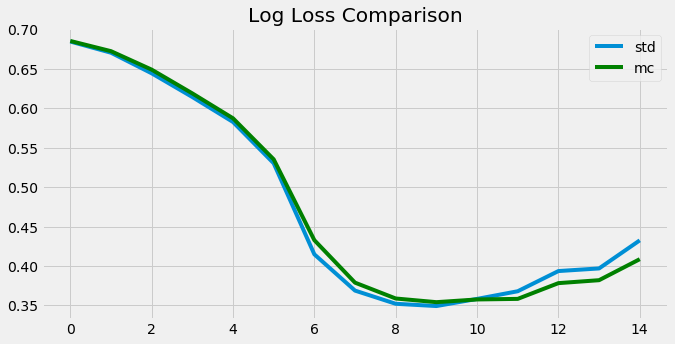

In [8]:
plt.title("Log Loss Comparison")
plt.plot(np.arange(len(modeltest_1.history)), [x[0] for x in modeltest_1.history], label="std")
plt.plot(np.arange(len(modeltest_1.history)), [x[1] for x in modeltest_1.history], "g-", label="mc")
plt.legend(loc='best')

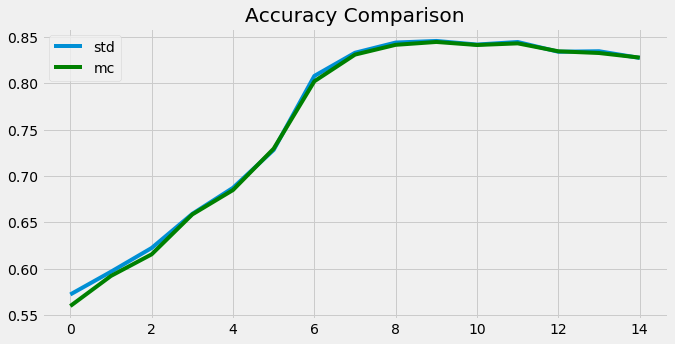

In [9]:
plt.title("Accuracy Comparison")
plt.plot(np.arange(0, len(modeltest_1.history)), [x[2] for x in modeltest_1.history], label="std")
plt.plot(np.arange(0, len(modeltest_1.history)), [x[3] for x in modeltest_1.history], "g-", label="mc")
plt.legend(loc='best')

## Standard LSTM
I choose to keep a very low weight decay because assigning zero seems to cause some problems.

In [10]:
print('Build model...')
model = get_model(edrop=0, rdrop=0, odrop=0, idrop=0, weight_decay=1e-10)

Build model...


In [11]:
modeltest_2 = ModelTest(X_test, Yt=Y_test,
                        test_every_X_epochs=1, verbose=0, T=1,
                        loss='binary', batch_size=TEST_BATCH_SIZE)

In [12]:
model.fit(
    X_train, Y_train,
    verbose=2,
    shuffle=True,
    # validation_data=[X_test, Y_test],
    batch_size=BATCH_SIZE, epochs=15, callbacks=[modeltest_2])

Epoch 1/15
Standard logloss/acc at epoch 00000: 0.5633/70.60%
MC logloss/acc at epoch 00000: 0.5633/70.60%
13s - loss: 0.6633 - binary_accuracy: 0.5787
Epoch 2/15
Standard logloss/acc at epoch 00001: 0.3998/81.79%
MC logloss/acc at epoch 00001: 0.3998/81.79%
12s - loss: 0.4352 - binary_accuracy: 0.7995
Epoch 3/15
Standard logloss/acc at epoch 00002: 0.3755/83.43%
MC logloss/acc at epoch 00002: 0.3755/83.43%
13s - loss: 0.3079 - binary_accuracy: 0.8731
Epoch 4/15
Standard logloss/acc at epoch 00003: 0.3776/83.54%
MC logloss/acc at epoch 00003: 0.3776/83.54%
13s - loss: 0.2446 - binary_accuracy: 0.9036
Epoch 5/15
Standard logloss/acc at epoch 00004: 0.3737/83.76%
MC logloss/acc at epoch 00004: 0.3737/83.76%
13s - loss: 0.1995 - binary_accuracy: 0.9254
Epoch 6/15
Standard logloss/acc at epoch 00005: 0.4408/83.27%
MC logloss/acc at epoch 00005: 0.4408/83.27%
13s - loss: 0.1534 - binary_accuracy: 0.9478
Epoch 7/15
Standard logloss/acc at epoch 00006: 0.5365/82.75%
MC logloss/acc at epoch 00

## LSTM with Standard Dropout (different mask at differnt time steps)

In [13]:
print('Build model...')
model = get_model(edrop=0.25, rdrop=0, odrop=0.25, idrop=0, weight_decay=1e-4)

Build model...


## Visualiaztions

In [14]:
modeltest_3 = ModelTest(X_test, Yt=Y_test,
                        test_every_X_epochs=1, verbose=0, T=10,
                        loss='binary', batch_size=TEST_BATCH_SIZE)

In [15]:
model.fit(
    X_train, Y_train,
    verbose=2,
    shuffle=True,
    # validation_data=[X_test, Y_test],
    batch_size=BATCH_SIZE, epochs=15, callbacks=[modeltest_3])

Epoch 1/15
Standard logloss/acc at epoch 00000: 0.6716/59.37%
MC logloss/acc at epoch 00000: 0.6728/59.26%
21s - loss: 74.7616 - binary_accuracy: 0.5363
Epoch 2/15
Standard logloss/acc at epoch 00001: 0.5568/71.37%
MC logloss/acc at epoch 00001: 0.5639/71.22%
20s - loss: 55.5015 - binary_accuracy: 0.6342
Epoch 3/15
Standard logloss/acc at epoch 00002: 0.4716/77.16%
MC logloss/acc at epoch 00002: 0.4721/77.50%
20s - loss: 40.9829 - binary_accuracy: 0.7410
Epoch 4/15
Standard logloss/acc at epoch 00003: 0.3992/82.14%
MC logloss/acc at epoch 00003: 0.4128/81.88%
20s - loss: 30.0969 - binary_accuracy: 0.7923
Epoch 5/15
Standard logloss/acc at epoch 00004: 0.3667/83.66%
MC logloss/acc at epoch 00004: 0.3745/83.36%
20s - loss: 21.9719 - binary_accuracy: 0.8274
Epoch 6/15
Standard logloss/acc at epoch 00005: 0.3575/84.12%
MC logloss/acc at epoch 00005: 0.3613/83.93%
20s - loss: 15.9622 - binary_accuracy: 0.8498
Epoch 7/15
Standard logloss/acc at epoch 00006: 0.3489/84.63%
MC logloss/acc at ep

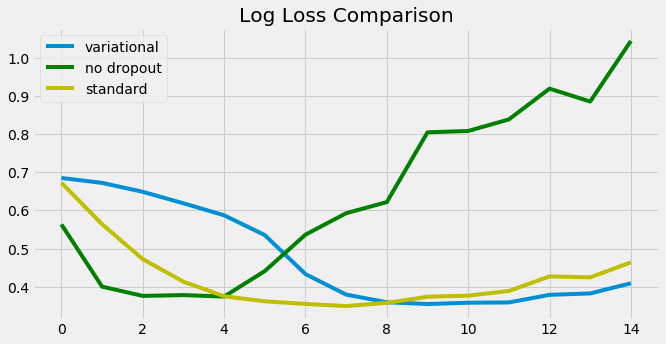

In [16]:
plt.title("Log Loss Comparison - Validation Set")
plt.plot(np.arange(len(modeltest_1.history)), [x[1] for x in modeltest_1.history], label="variational")
plt.plot(np.arange(len(modeltest_2.history)), [x[0] for x in modeltest_2.history], "g-", label="no dropout")
plt.plot(np.arange(len(modeltest_3.history)), [x[1] for x in modeltest_3.history], "y-", label="standard")
plt.legend(loc='best')

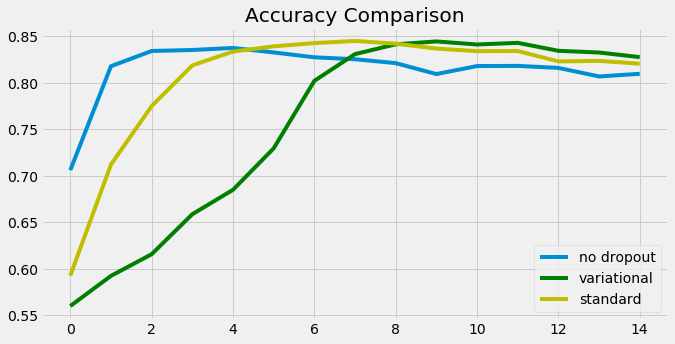

In [17]:
plt.title("Accuracy Comparison - Validation Set")
plt.plot(np.arange(len(modeltest_2.history)), [x[3] for x in modeltest_2.history], label="no dropout")
plt.plot(np.arange(len(modeltest_1.history)), [x[3] for x in modeltest_1.history], "g-", label="variational")
plt.plot(np.arange(len(modeltest_3.history)), [x[3] for x in modeltest_3.history], "y-", label="standard")
plt.legend(loc='best')